<a href="https://colab.research.google.com/github/Rhitabrat/deep-learning-CS510/blob/main/hw1/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Assignment 1<br>
CS 510: Deep Learning<br>
Winter 2022<br>
Instructor: Suresh Singh

In [8]:
# import required libraries
import numpy as np
import pandas as pd
from typing import List, Any
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision import transforms

##Load Fashion MNIST data

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
train_file_path = "/content/drive/Othercomputers/My MacBook Pro/PSU/Winter-2022/Deep Learning/Assignments/Assignment 1/FMNIST Dataset/fashion-mnist_train.csv"
test_file_path = "/content/drive/Othercomputers/My MacBook Pro/PSU/Winter-2022/Deep Learning/Assignments/Assignment 1/FMNIST Dataset/fashion-mnist_test.csv"

data_train = pd.read_csv(train_file_path)
data_test = pd.read_csv(test_file_path)

# let's see how our data looks like
data_train

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,0,0,105,92,101,107,100,132,0,0,2,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150,...,211,220,214,74,0,255,222,128,0,0,0,0,0,0,0,0,0,44,12,0,0,40,134,162,191,214,163,146,165,79,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,0,114,183,112,55,23,72,102,165,160,28,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,24,188,163,93,...,171,249,207,197,202,45,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,22,21,25,69,52,45,74,39,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,0,0,0,46,0,21,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,187,189,...,230,237,229,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,116,112,136,147,144,121,102,63,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
59996,1,0,0,0,0,0,0,0,0,0,0,83,155,136,116,148,110,118,67,32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,118,...,199,165,108,108,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,159,6,91,0,0,85,159,0,73,0,0,0,0,0,0,0,0,0
59997,8,0,0,0,0,0,0,0,0,0,0,1,0,0,87,114,77,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,...,228,229,231,231,218,230,255,0,0,0,0,0,0,0,0,0,0,0,116,140,147,166,176,174,173,173,174,173,177,164,160,162,163,135,94,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


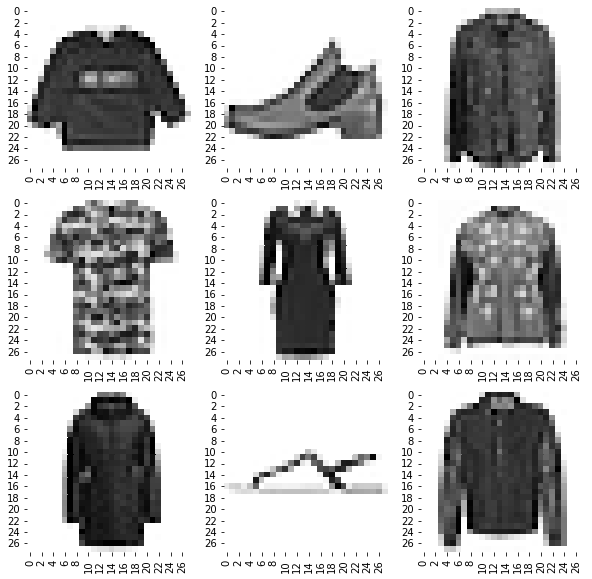

In [11]:
# visualizing some of the images

fig = plt.figure(figsize=(10,10))
for i in range(1,10):
    fig.add_subplot(3,3,i)
    sns.heatmap(np.array(data_train.iloc[i-1,1:]).reshape(28,28), cbar=False, cmap='Greys');

In [12]:
# getting the data ready for transforming
class FashionMNIST(Dataset):
    def __init__(self, data, transform=None):
        self.transform = transform
        self.labels = data.label.values
        self.images = data.iloc[:, 1:].values.astype('uint8').reshape(-1, 28, 28)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img = Image.fromarray(self.images[idx])
        
        if self.transform:
            img = self.transform(img)

        return img, label

In [13]:
# normalize the data and loading them for our model
data = pd.read_csv(train_file_path)
mean = np.array(data.iloc[:,1:]).flatten().mean()
std  = np.array(data.iloc[:,1:]).flatten().std()
transf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((mean/225,), (std/225,))])

data_test  = FashionMNIST(data_test,transform=transf)
data_train = FashionMNIST(data_train,transform=transf)

## Neural Network

In [14]:
# global variables

INPUT_SIZE = 784
OUTPUT_SIZE = 10

In [15]:
# create a class that implements a fully connected feed forward network

class NNetwork(torch.nn.Module):

    def __init__(self, hidden_size: List, activation):
        super().__init__()
        self.hidden_size = hidden_size
        self.activation = activation

        modules = []
        modules.append(nn.Linear(in_features=INPUT_SIZE, out_features=hidden_size[0]))
        modules.append(self.activation)

        for i in range(len(hidden_size) - 1):
            modules.append(nn.Linear(in_features=hidden_size[i], out_features=hidden_size[i + 1]))
            modules.append(self.activation)

        modules.append(nn.Linear(in_features=hidden_size[len(hidden_size) - 1], out_features=OUTPUT_SIZE))

        self.module_list = nn.ModuleList(modules=modules)

    def forward(self, x):

        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        for f in self.module_list:
            x = x.to(device)
            x = f(x)

        x = x.to(device)
        return x

In [22]:
# create test and train methods for testing and training the fully connected network

class FashionModel():

    def __init__(self, data_train, data_test, batch_size: int ) -> None:
        self.model = None
        self.params = []
        self.train_accuracy = []
        self.test_accuracy = []
        self.loss_train = []
        self.loss_test = []
        self.batch_size = batch_size
        self.criterion = nn.CrossEntropyLoss()
        self.data_train = data_train
        self.data_test = data_test


    def train(self, hidden_size: List, activation: Any, learn_rate: float, momentum: float, epochs: int) -> None:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        self.model = NNetwork(hidden_size=hidden_size, activation=activation)
        self.model.to(device)

        print(f"Hidden Layers: {hidden_size}")
        print(f"Learning Rate: {learn_rate}")
        print(f"Activation:    {activation.__str__()}")
        print(f"Batch Size:    {self.batch_size}")
        print(f"Epochs:        {epochs}")
        print('~' * 85)

        self.train_loader = torch.utils.data.DataLoader(dataset=self.data_train, batch_size=self.batch_size, shuffle=True)
        self.test_loader = torch.utils.data.DataLoader(dataset=self.data_test, batch_size=self.batch_size, shuffle=True)

        optimizer = torch.optim.SGD(params=self.model.parameters(), lr=learn_rate, momentum=momentum)

        for epoch in range(1, epochs + 1):
            for batch_id, (image, label) in enumerate(self.train_loader):

                image = image.view(image.shape[0],-1)
                device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
                image = image.to(device)
                label = label.to(device)
                output = self.model(image)
                loss = self.criterion(output, label)
                loss = loss.to()
                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(parameters=self.model.parameters(), max_norm=2.0, norm_type=2)
                optimizer.step()

            print(f"Epoch {epoch}/{epochs}  Training Loss: {loss.item():.4f}   ", end=' ')
            self.loss_train.append(loss.item())
            self.test()

        for i in self.model.parameters():
            self.params.append(i)

    def test(self) -> None:

        batch_length = len(self.test_loader)
        with torch.no_grad():
            correct = 0
            total = 0
            for batch_id, (image, label) in enumerate(self.test_loader, start=1):
                image = image.view(image.shape[0], -1)
                device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
                image = image.to(device)
                label = label.to(device)
                outputs = self.model(image)

                if (batch_id / batch_length == 1):
                    loss = self.criterion(outputs, label)
                    self.loss_test.append(loss.item())
                    print(f"Testing Loss: {loss.item():.4f}   ", end=' ')

                predicted = torch.argmax(input=outputs, dim=1)
                total += label.size(0)
                correct += (predicted == label).sum().item()

        accuracy = 100 * correct / total
        self.test_accuracy.append(accuracy)
        print(f"Testing Accuracy: {accuracy}%")

## Experiment 1 [Qn 2a]

In [23]:
hidden_size = [1024]
batch_size = 30
learn_rate = 0.001
activation = nn.ReLU()
momentum = 0
epochs = 2

model_1 = FashionModel(data_train=data_train, data_test=data_test, batch_size=batch_size)
model_1.train(hidden_size=hidden_size, activation=activation, learn_rate=learn_rate, momentum=momentum, epochs=epochs)

Hidden Layers: [1024]
Learning Rate: 0.001
Activation:    ReLU()
Batch Size:    30
Epochs:        2
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/2  Training Loss: 1.0090    Testing Loss: 0.6780    Testing Accuracy: 74.8%
Epoch 2/2  Training Loss: 0.7356    Testing Loss: 0.5795    Testing Accuracy: 78.4%


##Experiment 2 [Qn 2a]

In [24]:
hidden_size = [1024, 1024]
batch_size = 30
learn_rate = 0.001
activation = nn.ReLU()
momentum = 0
epochs = 2

model_2 = FashionModel(data_train=data_train, data_test=data_test, batch_size=batch_size)
model_2.train(hidden_size=hidden_size, activation=activation, learn_rate=learn_rate, momentum=momentum, epochs=epochs)

Hidden Layers: [1024, 1024]
Learning Rate: 0.001
Activation:    ReLU()
Batch Size:    30
Epochs:        2
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/2  Training Loss: 1.0065    Testing Loss: 0.7982    Testing Accuracy: 71.94%
Epoch 2/2  Training Loss: 0.6153    Testing Loss: 0.3005    Testing Accuracy: 76.23%


#Visualization

In [25]:
# %matplotlib inline
# %matplotlib notebook
# %matplotlib widget

# plt.rcParams['figure.figsize'] = [25, 10]
plt.rcParams['figure.figsize'] = [25, 5]

def display_model_visuals(model, title, hidden_size):

    # plot accuracy 
    plt.subplot(1,3,1)
    param_title = f"Hidden: {hidden_size}, batch: {model.batch_size}, η: {learn_rate}, φ: {activation.__str__()}"
    plt.plot(np.arange(epochs), model.test_accuracy, label='Test Accuracy')
    plt.title(f"{title}: Accuracy\n{param_title}")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.xticks(np.arange(len(model.test_accuracy)), np.arange(1, len(model.test_accuracy) + 1))
    plt.legend();

    # plot cross-entropy
    plt.subplot(1,3,2)
    param_title = f"Hidden: {hidden_size}, batch: {model.batch_size}, η: {learn_rate}, φ: {activation.__str__()}"
    plt.plot(np.arange(epochs), model.loss_train, label='Train Loss')
    plt.plot(np.arange(epochs), model.loss_test, label='Test Loss')
    plt.title(f"{title}: Cross Entropy Loss\n{param_title}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.xticks(np.arange(len(model.loss_test)), np.arange(1, len(model.loss_test) + 1))
    plt.legend();

    # create confusion matrix
    nb_classes = 10
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    with torch.no_grad():
        for i, (image, classes) in enumerate(model.test_loader):
            image = image.view(image.shape[0], -1)
            outputs = model.model(image)
            _, preds = torch.max(outputs, dim=1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

    cols = ["T-shirt/Top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag",
            "Ankle Boot"]
    plt.subplot(1,3,3)
    plt.title(f"{title}: Confusion Matrix\n{param_title}")
    sns.heatmap(pd.DataFrame(np.array(confusion_matrix), columns=cols, index=cols), cmap='Greys', annot=True, fmt='g');
    
    plt.show()

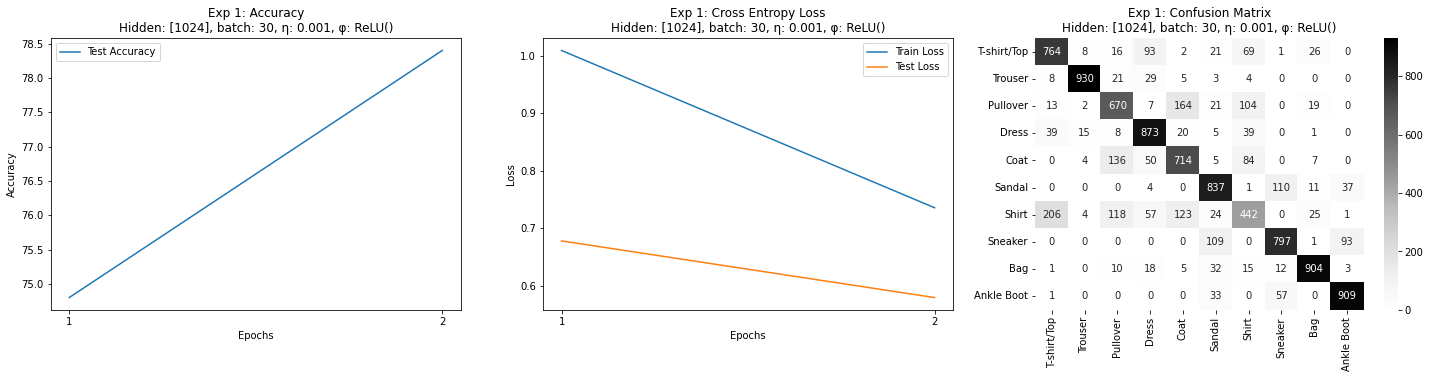

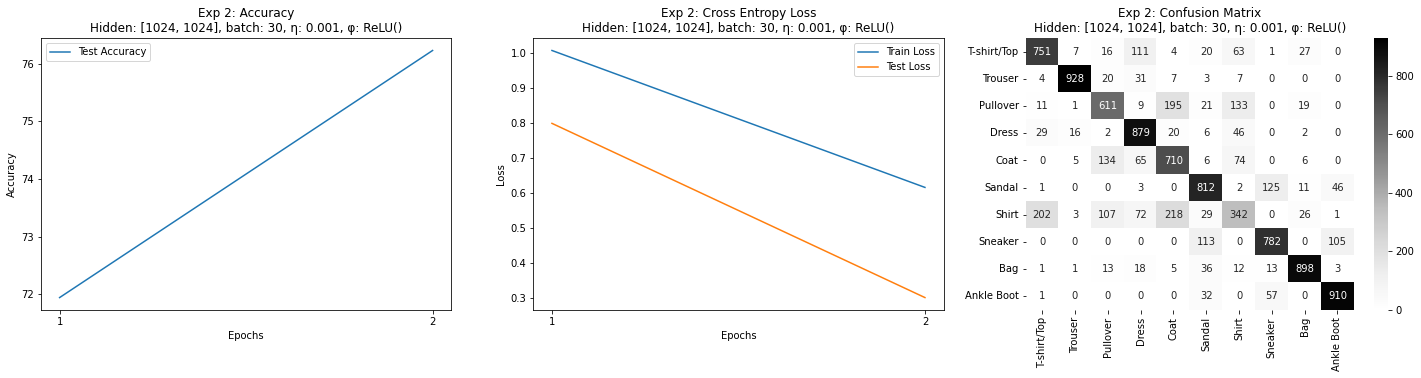

In [26]:
display_model_visuals(model=model_1, hidden_size=[1024], title="Exp 1")
display_model_visuals(model=model_2, hidden_size=[1024,1024], title="Exp 2")

## Experiment 3 [Qn 3]

CASE: 01
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Hidden Layers: [1024, 1024]
Learning Rate: 1
Activation:    ReLU()
Batch Size:    1
Epochs:        5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/5  Training Loss: 0.0000    Testing Loss: 1.8989    Testing Accuracy: 25.07%
Epoch 2/5  Training Loss: 2.2340    Testing Loss: 3.1425    Testing Accuracy: 22.23%
Epoch 3/5  Training Loss: 3.8857    Testing Loss: 2.3035    Testing Accuracy: 23.65%
Epoch 4/5  Training Loss: 3.1922    Testing Loss: 2.5505    Testing Accuracy: 28.26%
Epoch 5/5  Training Loss: 1.8077    Testing Loss: 1.0847    Testing Accuracy: 20.66%


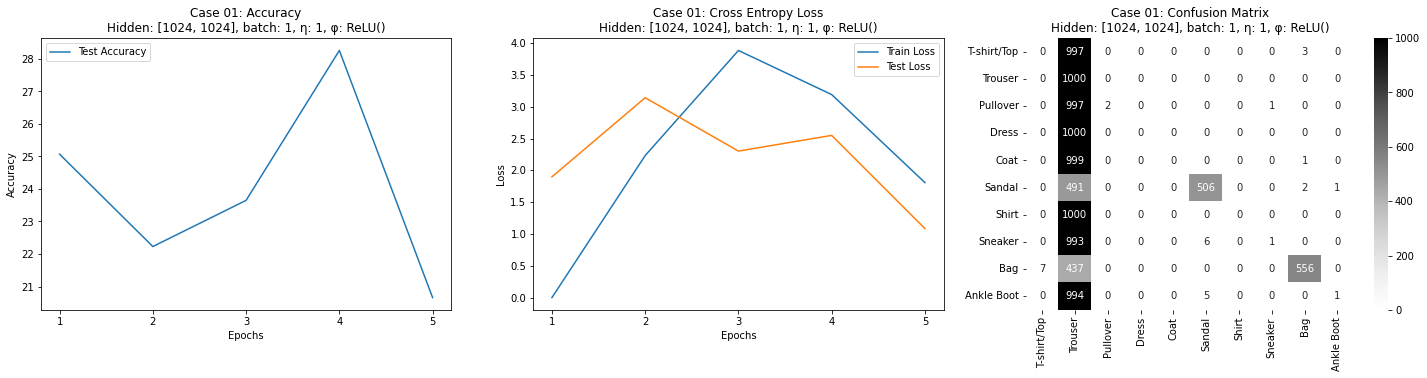

CASE: 02
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Hidden Layers: [1024, 1024]
Learning Rate: 0.1
Activation:    ReLU()
Batch Size:    1
Epochs:        5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/5  Training Loss: 0.0000    Testing Loss: 0.0083    Testing Accuracy: 85.84%
Epoch 2/5  Training Loss: 5.8223    Testing Loss: 0.0374    Testing Accuracy: 86.9%
Epoch 3/5  Training Loss: 0.0003    Testing Loss: 0.0000    Testing Accuracy: 88.1%
Epoch 4/5  Training Loss: 0.0006    Testing Loss: 2.3913    Testing Accuracy: 88.84%
Epoch 5/5  Training Loss: 0.0000    Testing Loss: 0.0000    Testing Accuracy: 88.3%


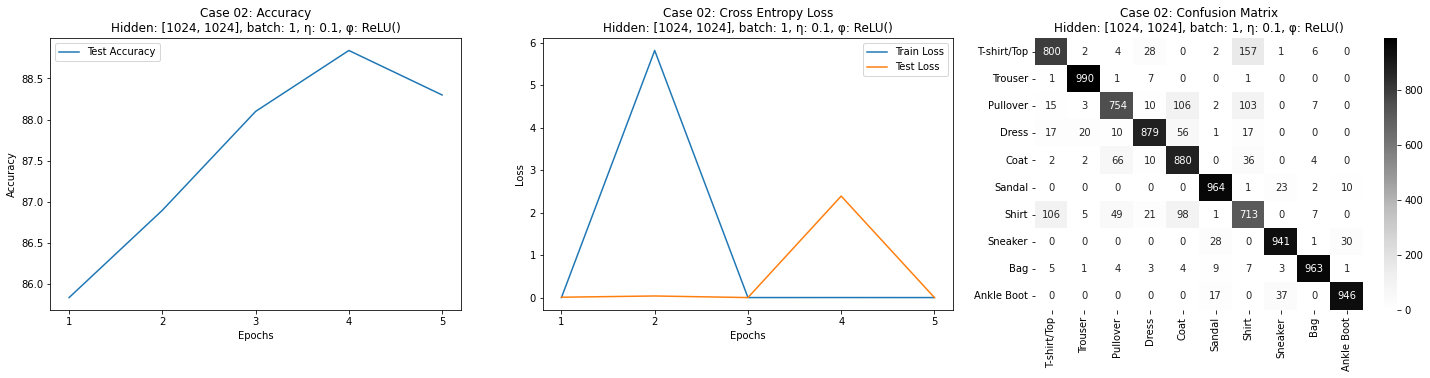

CASE: 03
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Hidden Layers: [1024, 1024]
Learning Rate: 0.01
Activation:    ReLU()
Batch Size:    1
Epochs:        5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/5  Training Loss: 2.1126    Testing Loss: 0.0000    Testing Accuracy: 85.63%
Epoch 2/5  Training Loss: 0.0001    Testing Loss: 0.0288    Testing Accuracy: 86.6%
Epoch 3/5  Training Loss: 0.0000    Testing Loss: 1.8323    Testing Accuracy: 87.27%
Epoch 4/5  Training Loss: 0.0001    Testing Loss: 0.0027    Testing Accuracy: 88.54%
Epoch 5/5  Training Loss: 0.0039    Testing Loss: 0.0000    Testing Accuracy: 88.51%


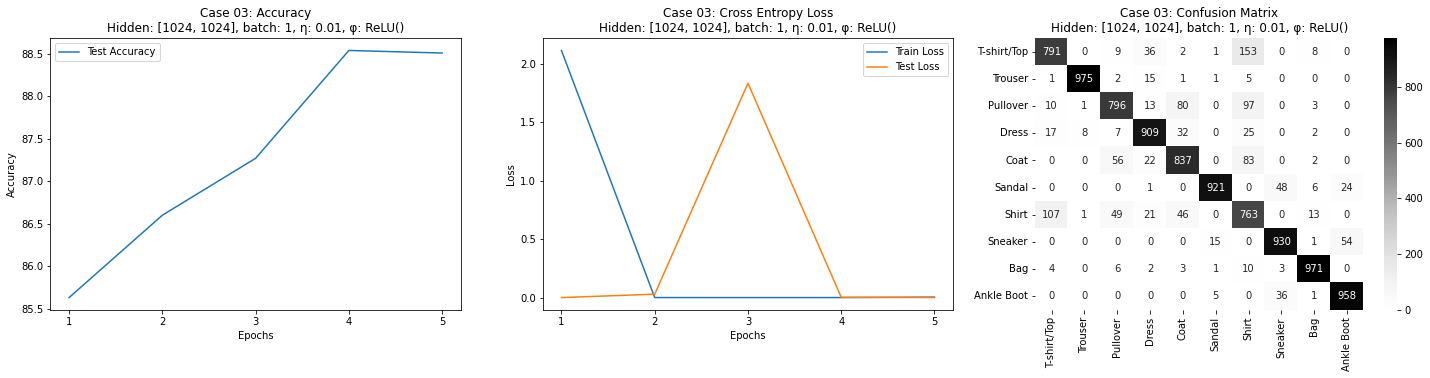

CASE: 04
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Hidden Layers: [1024, 1024]
Learning Rate: 0.001
Activation:    ReLU()
Batch Size:    1
Epochs:        5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/5  Training Loss: 0.0010    Testing Loss: 4.3039    Testing Accuracy: 78.1%
Epoch 2/5  Training Loss: 0.0480    Testing Loss: 0.0428    Testing Accuracy: 81.44%
Epoch 3/5  Training Loss: 0.0006    Testing Loss: 0.0002    Testing Accuracy: 82.94%
Epoch 4/5  Training Loss: 0.0001    Testing Loss: 0.0000    Testing Accuracy: 83.53%
Epoch 5/5  Training Loss: 0.4965    Testing Loss: 0.0008    Testing Accuracy: 84.38%


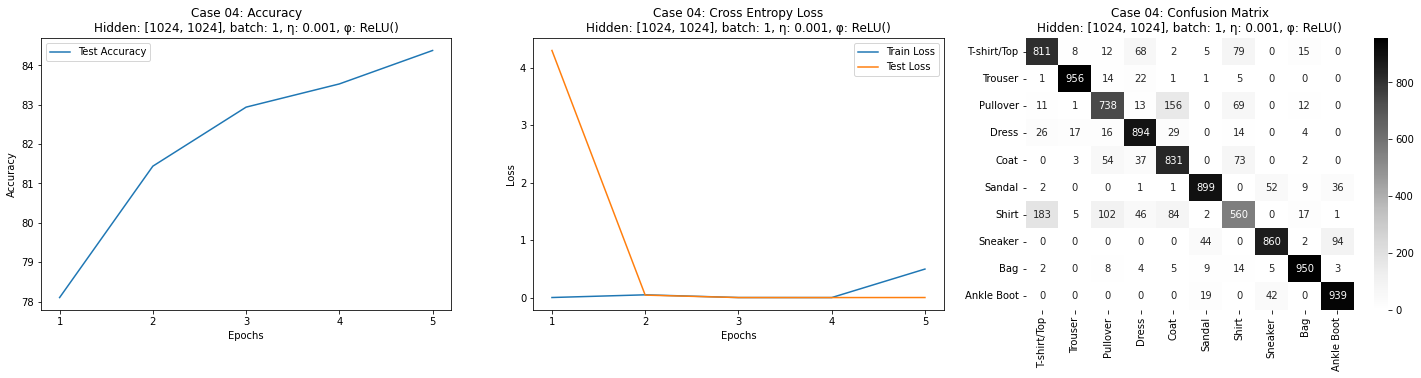

CASE: 05
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Hidden Layers: [1024, 1024]
Learning Rate: 1
Activation:    Sigmoid()
Batch Size:    1
Epochs:        5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/5  Training Loss: 0.0000    Testing Loss: 0.0696    Testing Accuracy: 76.48%
Epoch 2/5  Training Loss: 12.8008    Testing Loss: 0.0000    Testing Accuracy: 78.48%
Epoch 3/5  Training Loss: 17.3221    Testing Loss: 0.0000    Testing Accuracy: 73.9%
Epoch 4/5  Training Loss: 0.0000    Testing Loss: 17.0188    Testing Accuracy: 73.36%
Epoch 5/5  Training Loss: 0.0000    Testing Loss: 0.0000    Testing Accuracy: 75.88%


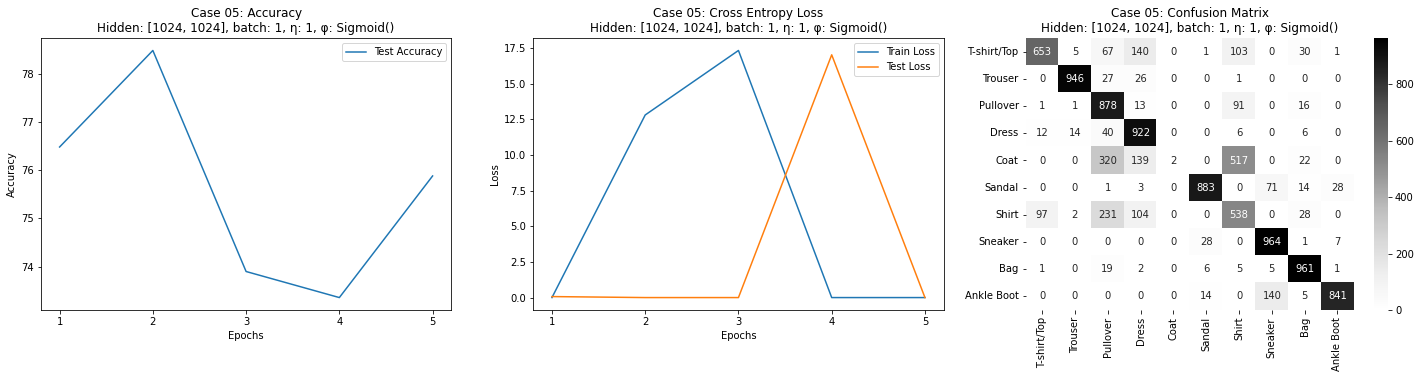

CASE: 06
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Hidden Layers: [1024, 1024]
Learning Rate: 0.1
Activation:    Sigmoid()
Batch Size:    1
Epochs:        5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/5  Training Loss: 0.2261    Testing Loss: 3.3324    Testing Accuracy: 82.9%
Epoch 2/5  Training Loss: 0.0001    Testing Loss: 2.5552    Testing Accuracy: 86.19%
Epoch 3/5  Training Loss: 0.0590    Testing Loss: 0.0180    Testing Accuracy: 86.91%
Epoch 4/5  Training Loss: 0.3202    Testing Loss: 0.0068    Testing Accuracy: 87.35%
Epoch 5/5  Training Loss: 0.0000    Testing Loss: 0.3148    Testing Accuracy: 88.26%


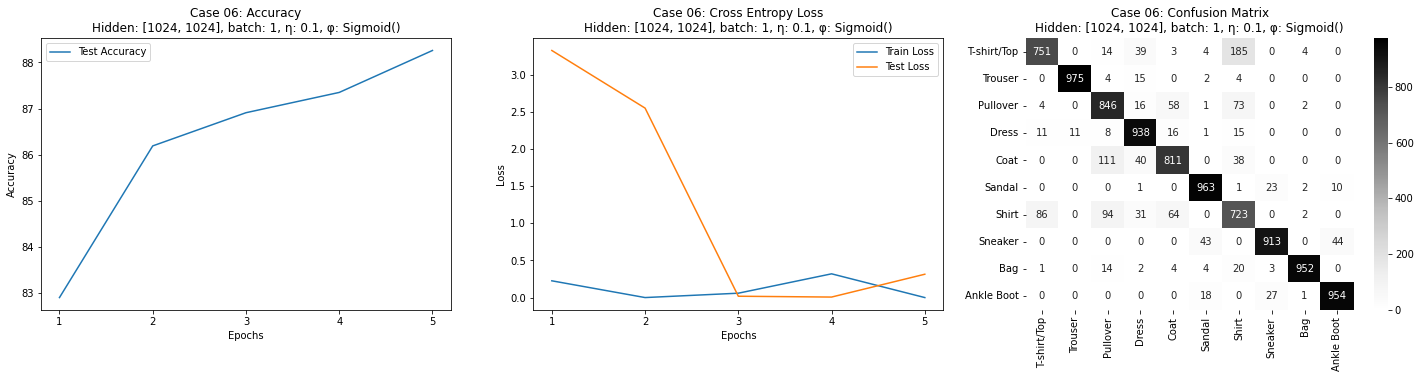

CASE: 07
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Hidden Layers: [1024, 1024]
Learning Rate: 0.01
Activation:    Sigmoid()
Batch Size:    1
Epochs:        5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/5  Training Loss: 1.4441    Testing Loss: 0.9388    Testing Accuracy: 76.04%
Epoch 2/5  Training Loss: 0.0008    Testing Loss: 0.0017    Testing Accuracy: 82.05%
Epoch 3/5  Training Loss: 0.0175    Testing Loss: 0.0029    Testing Accuracy: 83.28%
Epoch 4/5  Training Loss: 0.0003    Testing Loss: 0.0002    Testing Accuracy: 84.43%
Epoch 5/5  Training Loss: 0.9781    Testing Loss: 0.0007    Testing Accuracy: 84.91%


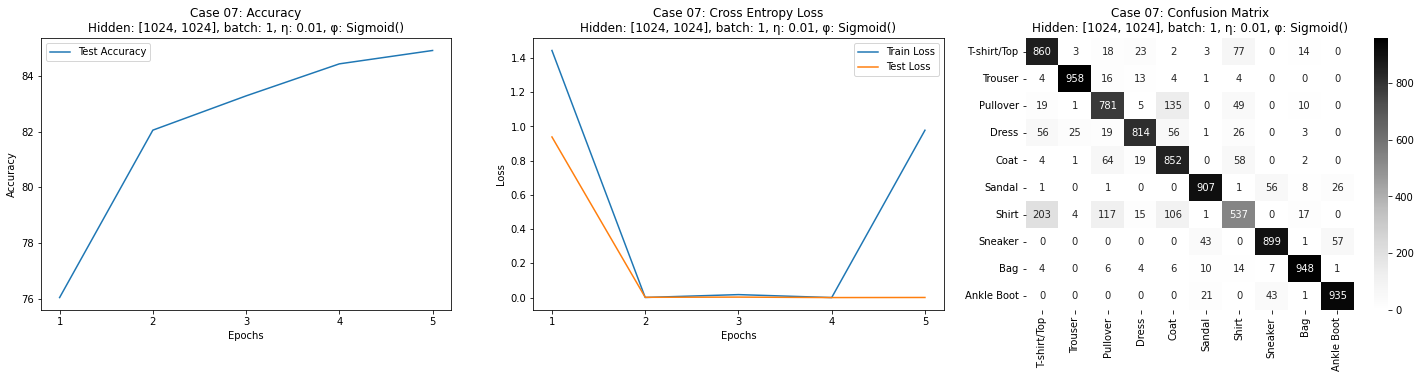

CASE: 08
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Hidden Layers: [1024, 1024]
Learning Rate: 0.001
Activation:    Sigmoid()
Batch Size:    1
Epochs:        5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/5  Training Loss: 2.1171    Testing Loss: 1.7072    Testing Accuracy: 45.8%
Epoch 2/5  Training Loss: 1.0085    Testing Loss: 0.5253    Testing Accuracy: 54.18%
Epoch 3/5  Training Loss: 1.0002    Testing Loss: 1.5552    Testing Accuracy: 57.44%
Epoch 4/5  Training Loss: 0.0212    Testing Loss: 0.4330    Testing Accuracy: 65.72%
Epoch 5/5  Training Loss: 0.3854    Testing Loss: 0.0060    Testing Accuracy: 70.16%


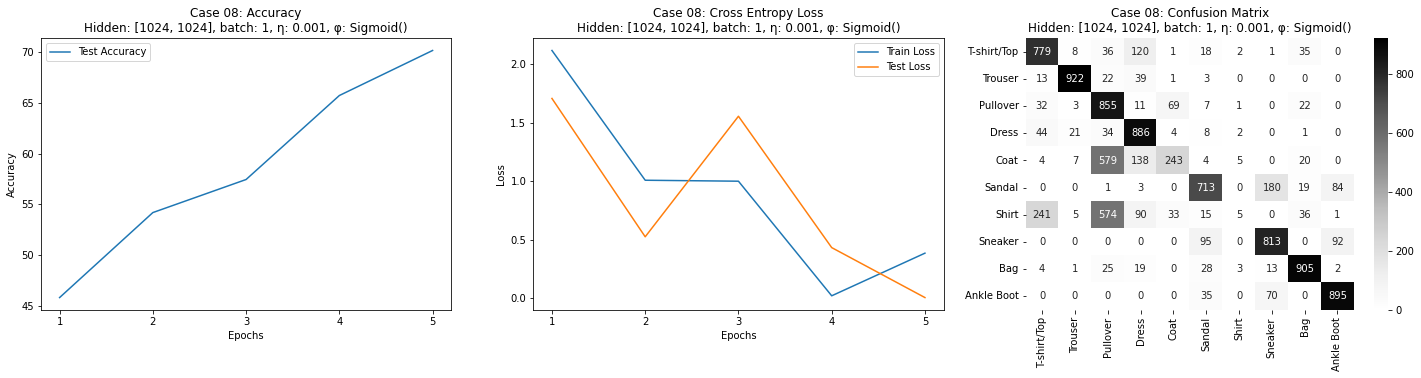

CASE: 09
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Hidden Layers: [1024, 1024]
Learning Rate: 1
Activation:    ReLU()
Batch Size:    10
Epochs:        5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/5  Training Loss: 3.8500    Testing Loss: 1.4151    Testing Accuracy: 31.32%
Epoch 2/5  Training Loss: 1.1623    Testing Loss: 1.4040    Testing Accuracy: 33.96%
Epoch 3/5  Training Loss: 1.5484    Testing Loss: 1.4290    Testing Accuracy: 31.32%
Epoch 4/5  Training Loss: 1.3611    Testing Loss: 1.1365    Testing Accuracy: 36.14%
Epoch 5/5  Training Loss: 1.6194    Testing Loss: 1.5532    Testing Accuracy: 35.88%


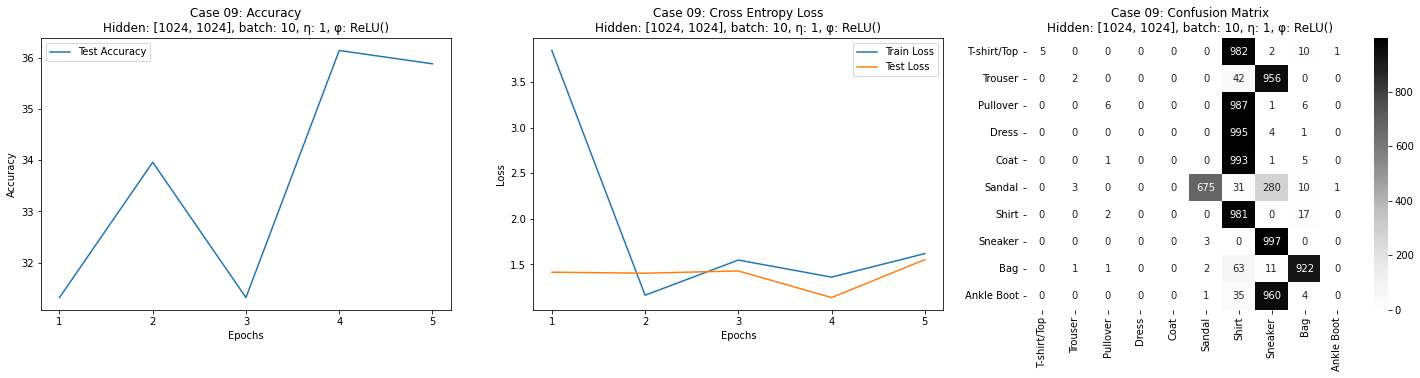

CASE: 10
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Hidden Layers: [1024, 1024]
Learning Rate: 0.1
Activation:    ReLU()
Batch Size:    10
Epochs:        5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/5  Training Loss: 0.8399    Testing Loss: 0.1394    Testing Accuracy: 86.75%
Epoch 2/5  Training Loss: 0.4262    Testing Loss: 0.1734    Testing Accuracy: 87.45%
Epoch 3/5  Training Loss: 0.1527    Testing Loss: 0.3385    Testing Accuracy: 87.94%
Epoch 4/5  Training Loss: 0.0441    Testing Loss: 0.1489    Testing Accuracy: 88.65%
Epoch 5/5  Training Loss: 0.3449    Testing Loss: 0.1525    Testing Accuracy: 88.81%


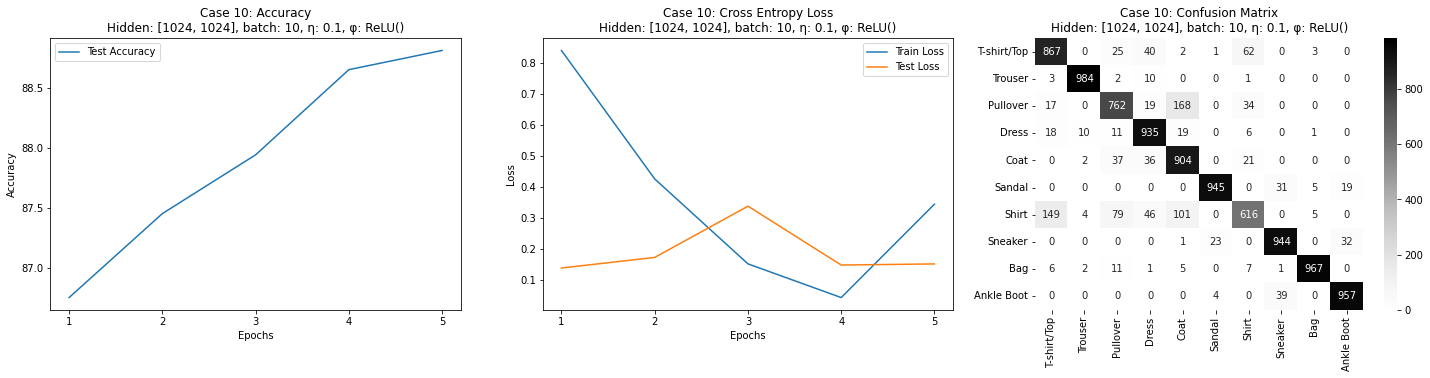

CASE: 11
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Hidden Layers: [1024, 1024]
Learning Rate: 0.01
Activation:    ReLU()
Batch Size:    10
Epochs:        5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/5  Training Loss: 0.2616    Testing Loss: 0.4187    Testing Accuracy: 84.33%
Epoch 2/5  Training Loss: 0.4923    Testing Loss: 1.0420    Testing Accuracy: 86.13%
Epoch 3/5  Training Loss: 1.3580    Testing Loss: 0.4396    Testing Accuracy: 87.09%
Epoch 4/5  Training Loss: 0.0540    Testing Loss: 1.3278    Testing Accuracy: 87.3%
Epoch 5/5  Training Loss: 0.2981    Testing Loss: 0.5626    Testing Accuracy: 87.81%


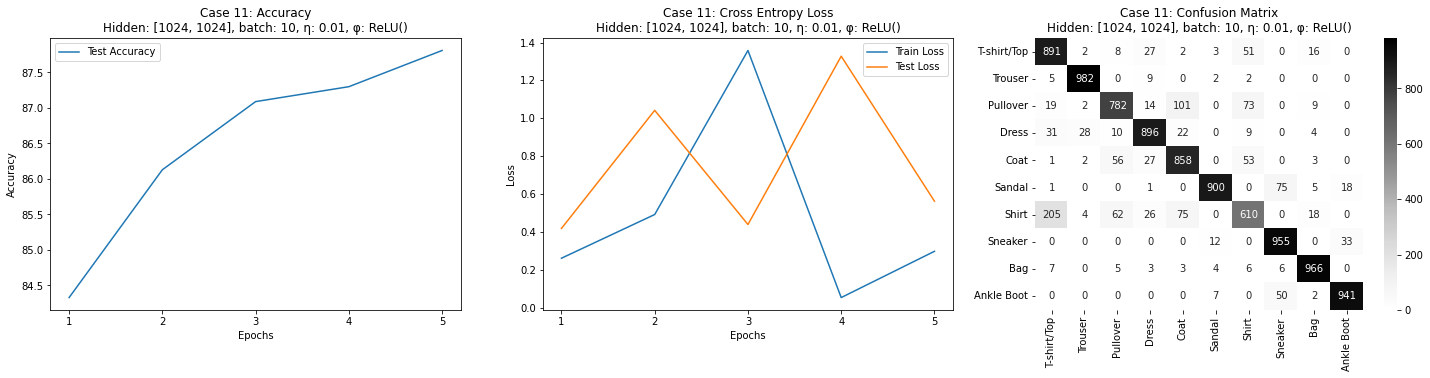

CASE: 12
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Hidden Layers: [1024, 1024]
Learning Rate: 0.001
Activation:    ReLU()
Batch Size:    10
Epochs:        5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/5  Training Loss: 0.5937    Testing Loss: 0.8349    Testing Accuracy: 75.85%
Epoch 2/5  Training Loss: 0.4138    Testing Loss: 0.7737    Testing Accuracy: 79.37%
Epoch 3/5  Training Loss: 0.3382    Testing Loss: 0.6936    Testing Accuracy: 81.34%
Epoch 4/5  Training Loss: 0.3928    Testing Loss: 0.3211    Testing Accuracy: 82.35%
Epoch 5/5  Training Loss: 0.7086    Testing Loss: 0.4788    Testing Accuracy: 83.06%


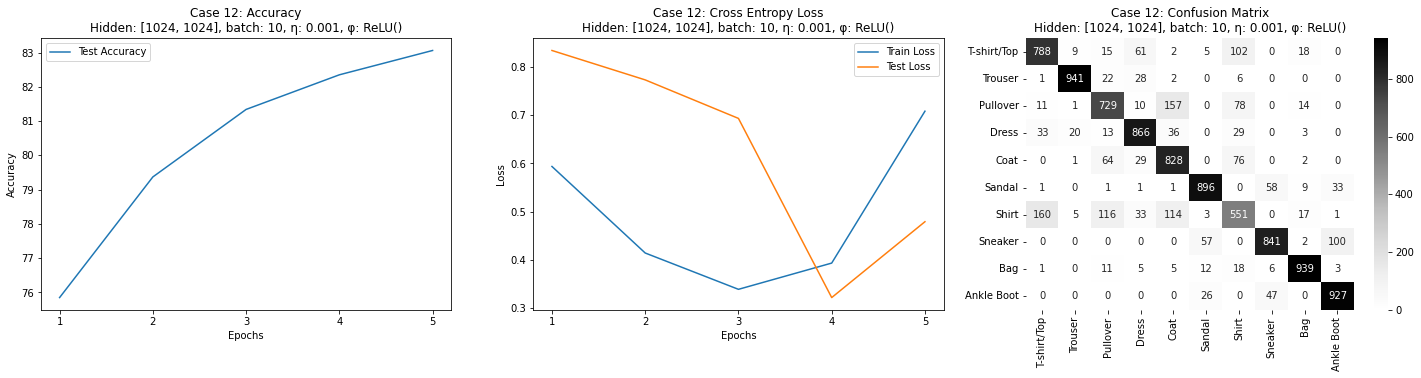

CASE: 13
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Hidden Layers: [1024, 1024]
Learning Rate: 1
Activation:    Sigmoid()
Batch Size:    10
Epochs:        5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/5  Training Loss: 0.3268    Testing Loss: 0.6150    Testing Accuracy: 83.54%
Epoch 2/5  Training Loss: 0.4817    Testing Loss: 0.2264    Testing Accuracy: 86.32%
Epoch 3/5  Training Loss: 0.5122    Testing Loss: 0.5315    Testing Accuracy: 84.87%
Epoch 4/5  Training Loss: 0.3078    Testing Loss: 0.1374    Testing Accuracy: 86.51%
Epoch 5/5  Training Loss: 0.6381    Testing Loss: 0.6279    Testing Accuracy: 83.12%


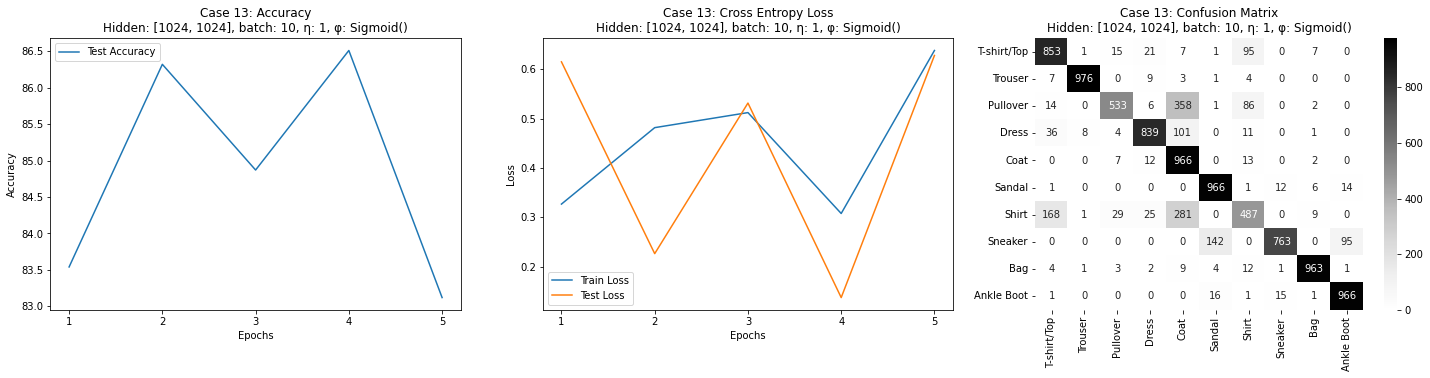

CASE: 14
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Hidden Layers: [1024, 1024]
Learning Rate: 0.1
Activation:    Sigmoid()
Batch Size:    10
Epochs:        5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/5  Training Loss: 0.4386    Testing Loss: 0.1318    Testing Accuracy: 81.61%
Epoch 2/5  Training Loss: 0.1165    Testing Loss: 0.1735    Testing Accuracy: 84.73%
Epoch 3/5  Training Loss: 0.3876    Testing Loss: 0.1279    Testing Accuracy: 86.49%
Epoch 4/5  Training Loss: 0.1049    Testing Loss: 0.3596    Testing Accuracy: 86.73%
Epoch 5/5  Training Loss: 0.0901    Testing Loss: 0.4937    Testing Accuracy: 87.41%


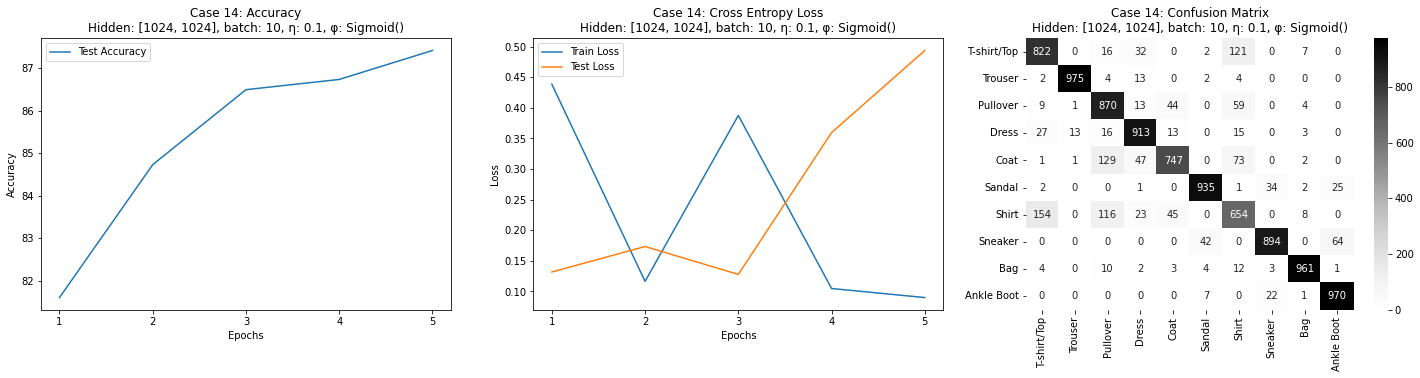

CASE: 15
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Hidden Layers: [1024, 1024]
Learning Rate: 0.01
Activation:    Sigmoid()
Batch Size:    10
Epochs:        5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/5  Training Loss: 0.8902    Testing Loss: 0.8274    Testing Accuracy: 66.8%
Epoch 2/5  Training Loss: 0.3375    Testing Loss: 0.6205    Testing Accuracy: 74.23%
Epoch 3/5  Training Loss: 0.2757    Testing Loss: 0.8645    Testing Accuracy: 78.5%
Epoch 4/5  Training Loss: 0.2620    Testing Loss: 0.2928    Testing Accuracy: 79.62%
Epoch 5/5  Training Loss: 0.2806    Testing Loss: 0.7080    Testing Accuracy: 82.33%


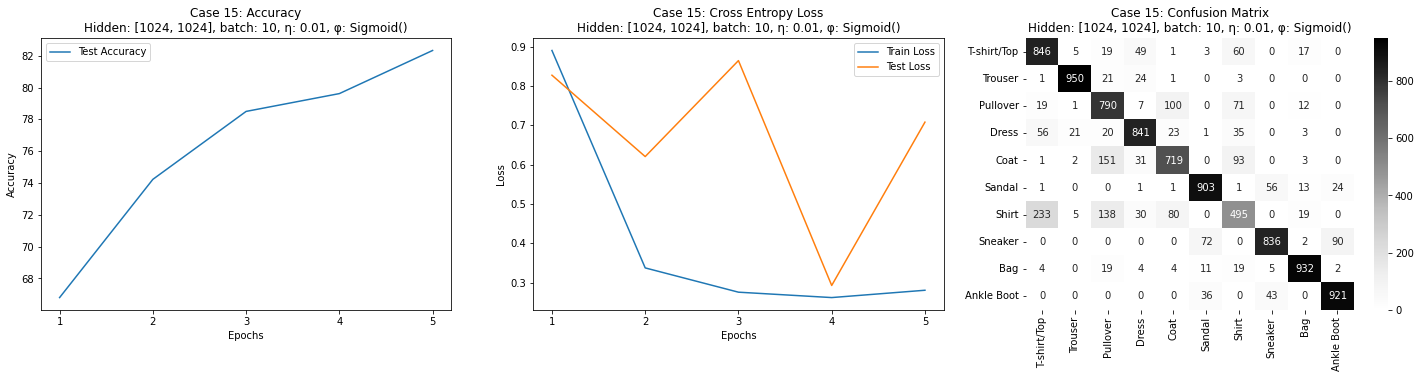

CASE: 16
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Hidden Layers: [1024, 1024]
Learning Rate: 0.001
Activation:    Sigmoid()
Batch Size:    10
Epochs:        5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/5  Training Loss: 2.2181    Testing Loss: 2.2215    Testing Accuracy: 40.41%
Epoch 2/5  Training Loss: 2.1367    Testing Loss: 2.1424    Testing Accuracy: 52.82%
Epoch 3/5  Training Loss: 1.7827    Testing Loss: 1.9053    Testing Accuracy: 52.04%
Epoch 4/5  Training Loss: 1.6151    Testing Loss: 1.5946    Testing Accuracy: 54.81%
Epoch 5/5  Training Loss: 1.6237    Testing Loss: 1.3704    Testing Accuracy: 57.16%


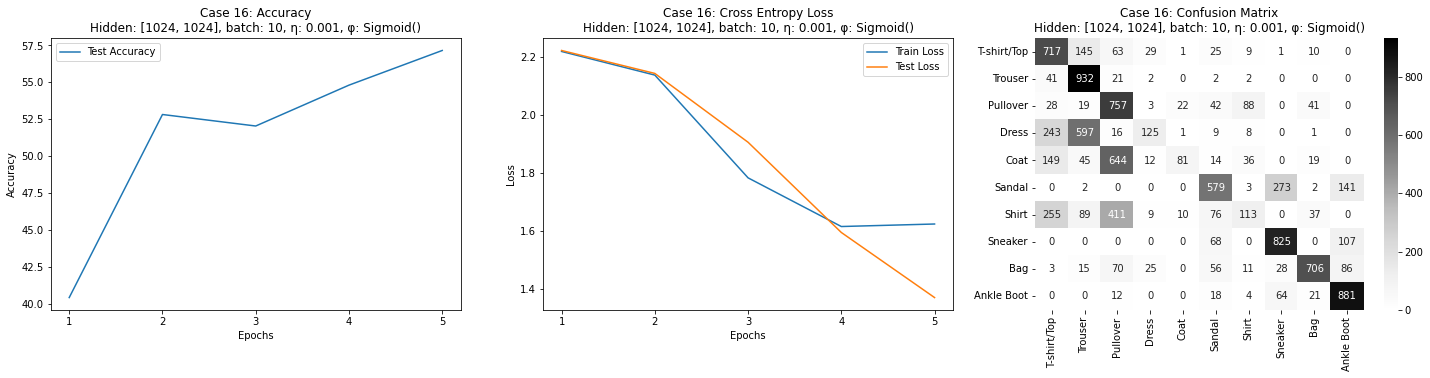

CASE: 17
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Hidden Layers: [1024, 1024]
Learning Rate: 1
Activation:    ReLU()
Batch Size:    1000
Epochs:        5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [ ]:
hidden_size = [1024, 1024]
momentum = 0
epochs = 5

params = {
    'batch_size': [1, 10, 1000],
    'activation': [nn.ReLU(), nn.Sigmoid()],
    'learn_rate': [1, 0.1, 0.01, 0.001],
}

i = 0
for batch_size in params['batch_size']:
    for activation in params['activation']:
        for learn_rate in params['learn_rate']:
            i += 1

            print(f"CASE: {i:02d}")
            print("~"*85)

            model = FashionModel(data_train=data_train, data_test=data_test, batch_size=batch_size)
            model.train(hidden_size=hidden_size, activation=activation, 
                        learn_rate=learn_rate, momentum=momentum, epochs=epochs)

            display_model_visuals(model=model, hidden_size=hidden_size, title=f"Case {i:02d}");

##Data Pollution

Pick 9 sets of 1% of images from each of the 10 categories and add them to the other 9 categories.

In [ ]:
# pollute the data as stated
data_train = pd.read_csv(train_file_path)

df_pollution = pd.DataFrame()
df_duplicate = pd.DataFrame()
df_concat = pd.DataFrame()

for i in range(10):
    df = data_train.loc[data_train.label == i]
    df = df.sample(frac=0.1)
    for j in range(10):
        if j==i:
            continue
        df.label = j
        df_pollution = df_pollution.append(df)
        df_duplicate = df_duplicate.append(df)

df_concat = df_pollution.append(data_train)

# remove duplicates
df_polluted = pd.merge(df_concat, df_duplicate, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)
df_polluted

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
54000,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
54001,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
54002,6,0,0,0,0,0,0,0,5,0,0,0,105,92,101,107,100,132,0,0,2,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150,...,211,220,214,74,0,255,222,128,0,0,0,0,0,0,0,0,0,44,12,0,0,40,134,162,191,214,163,146,165,79,0,0,0,30,43,0,0,0,0,0
54003,0,0,0,0,1,2,0,0,0,0,0,114,183,112,55,23,72,102,165,160,28,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,24,188,163,93,...,171,249,207,197,202,45,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,22,21,25,69,52,45,74,39,3,0,0,0,0,1,0,0,0,0
54004,3,0,0,0,0,0,0,0,0,0,0,0,0,46,0,21,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,187,189,...,230,237,229,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,116,112,136,147,144,121,102,63,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113995,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
113996,1,0,0,0,0,0,0,0,0,0,0,83,155,136,116,148,110,118,67,32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,118,...,199,165,108,108,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,159,6,91,0,0,85,159,0,73,0,0,0,0,0,0,0,0,0
113997,8,0,0,0,0,0,0,0,0,0,0,1,0,0,87,114,77,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,...,228,229,231,231,218,230,255,0,0,0,0,0,0,0,0,0,0,0,116,140,147,166,176,174,173,173,174,173,177,164,160,162,163,135,94,0,0,0,0,0
113998,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# normalize the data and loading them for our model

mean = np.array(df_polluted.iloc[:,1:]).flatten().mean()
std  = np.array(df_polluted.iloc[:,1:]).flatten().std()
transf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((mean/225,), (std/225,))])

data_train_polluted = FashionMNIST(df_polluted, transform=transf)

## Experiment 4 [Qn 4]

--------------------------------------------------------
TestFashionModel.test_part1_polluted: 01/20/2022 07:42:15
--------------------------------------------------------
Hidden Layers: [1024, 1024]
Learning Rate: 0.1
Activation:    ReLU()
Batch Size:    1
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 0.0002    Testing Loss: 0.0094    Testing Accuracy: 84.84%
Epoch 2/2  Training Loss: 0.0001    Testing Loss: 4.3137    Testing Accuracy: 86.56%


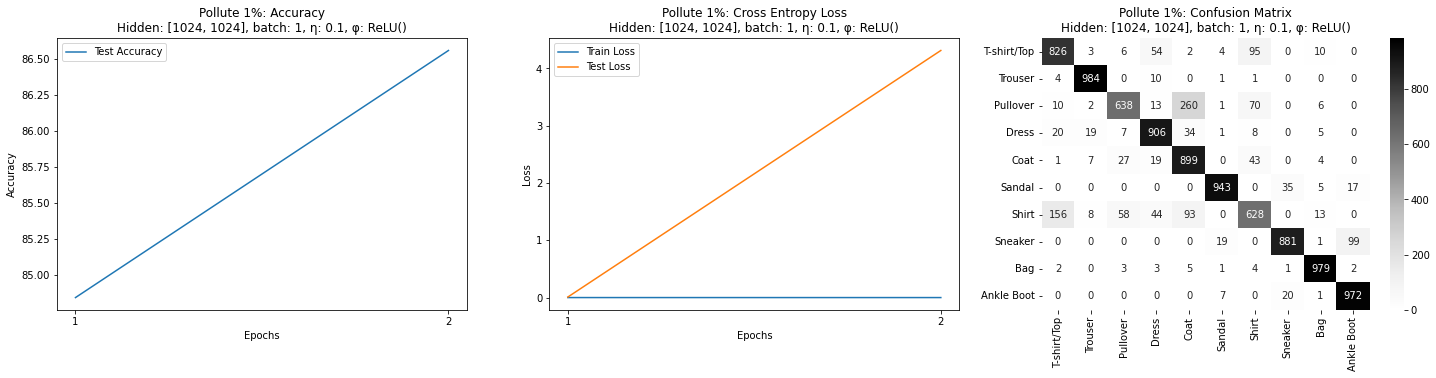

Time taken: 0:05:33.478389 Elapsed




In [ ]:
hidden_size = [1024, 1024]
batch_size = 1
learn_rate = 0.1
activation = nn.ReLU()
momentum = 0
epochs = 5

model_polluted = FashionModel(data_train=data_train_polluted, data_test=data_test, batch_size=batch_size)
model_polluted.train(hidden_size=hidden_size, activation=activation, learn_rate=learn_rate, momentum=momentum, epochs=epochs)

display_model_visuals(model=model_polluted, hidden_size=hidden_size, title="1% Polluted Data")

## Circular Shift

In [16]:
data_test = pd.read_csv(test_file_path)

def shift_right(n):
    right_cols = data_test.iloc[:, -2:]
    left_cols = data_test.iloc[:, 1:-2]
    shifted = pd.concat([right_cols, left_cols], axis=1)
    # shifted = pd.concat([right_cols, left_cols.reindex(right_cols.index)], axis=1)
    shifted.columns = data_test.columns[1:]
    shifted.insert(loc=0, column='label', value=data_test.label)
    return shifted

In [17]:
shifted_df = shift_right(2)
shifted_df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,9,8,0,0,34,29,7,0,11,24,0,0,3,3,1,0,1,1,0,0,0,0,0,4,0,0,1,0,0,0,...,232,236,242,245,224,245,234,0,3,0,0,0,0,0,0,0,0,0,0,0,0,37,69,94,123,127,138,138,142,145,135,125,103,87,56,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,209,190,181,150,170,193,180,219,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,87,248,238,80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,174,233,155,0,65,235,216,34,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,14,53,99,17,0,0,0,0,0,0,0,0,12,94,68,14,0,0,0,0,0,0,0,0,0,0,0,38,106,94,89,...,0,0,0,0,0,0,0,0,87,12,26,0,0,0,0,0,0,0,46,50,29,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,63,53,31,0
3,2,0,0,0,0,0,0,0,0,0,0,0,161,212,138,150,169,164,176,202,255,183,26,0,0,0,0,0,0,0,0,0,0,0,1,0,0,129,221,255,...,255,255,255,255,254,252,255,101,196,254,252,100,0,0,0,0,0,168,232,225,0,41,172,147,148,153,155,146,137,141,143,137,137,126,140,0,133,224,222,56
4,3,0,0,0,0,0,0,0,0,0,0,0,0,37,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,...,2,70,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,69,0,2,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,0,0,37,93,72,58,55,63,66,89,159,120,20,0,0,0,0,1,0,0,0,0,0,0,1,0,0,22,67,125,...,124,112,112,115,117,117,113,146,41,0,3,0,0,0,0,0,0,0,1,0,1,76,54,55,51,53,53,55,53,44,38,37,32,23,14,20,0,0,1,0
9996,6,0,0,0,0,0,0,0,0,0,0,0,0,0,76,36,110,170,78,136,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,110,86,94,84,70,44,0,36,152,65,110,0,0,0,0,0,0,0,21,57,89,7,0,0,0,0,0,0,0,0,0,0,0,0,0,2,52,23,28,0
9997,8,1,0,0,0,0,0,0,0,0,0,0,0,1,3,0,14,152,184,158,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,213,214,219,223,226,239,247,241,224,213,144,0,0,0,0,0,0,1,0,44,232,199,200,190,180,179,185,189,191,185,179,178,175,172,172,182,199,222,42,0
9998,8,0,0,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,131,192,79,0,0,...,219,77,13,26,17,8,0,0,0,0,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


## Experiment 5 [Qn 5]

In [19]:
# normalize the data and loading them for our model
mean = np.array(data.iloc[:,1:]).flatten().mean()
std  = np.array(data.iloc[:,1:]).flatten().std()
transf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((mean/225,), (std/225,))])

data_train = pd.read_csv(train_file_path)
data_test  = FashionMNIST(shifted_df,transform=transf)
data_train = FashionMNIST(data_train,transform=transf)

# Although it looks like I am doing training here, I am not training on the shifted dataset, 
# I am sure I am testing on the shifted dataset. I am testing on all epochs.

hidden_size = [1024, 1024]
batch_size = 30
learn_rate = 0.001
activation = nn.ReLU()
momentum = 0
epochs = 5

model_2 = FashionModel(data_train=data_train, data_test=data_test, batch_size=batch_size)
model_2.train(hidden_size=hidden_size, activation=activation, learn_rate=learn_rate, momentum=momentum, epochs=epochs)

Hidden Layers: [1024, 1024]
Learning Rate: 0.001
Activation:    ReLU()
Batch Size:    30
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 0.7658    Testing Loss: 1.4125    Testing Accuracy: 56.94%
Epoch 2/2  Training Loss: 0.8110    Testing Loss: 1.1227    Testing Accuracy: 58.41%


## Down Shift

In [21]:
data_test = pd.read_csv(test_file_path)

def shift_down(n):
    down_shifted = data_test.shift(periods=2)
    top_rows = data_test[:2]
    for i in range(2):
        down_shifted.loc[i] = top_rows.loc[i]
    return down_shifted

In [22]:
shifted_df = shift_down(2)
shifted_df = shifted_df.astype(int)
shifted_df

## Experiment 6 [Qn 5]

In [23]:
# normalize the data and loading them for our model
mean = np.array(data.iloc[:,1:]).flatten().mean()
std  = np.array(data.iloc[:,1:]).flatten().std()
transf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((mean/225,), (std/225,))])

data_train = pd.read_csv(train_file_path)
data_test  = FashionMNIST(shifted_df,transform=transf)
data_train = FashionMNIST(data_train,transform=transf)


hidden_size = [1024, 1024]
batch_size = 30
learn_rate = 0.001
activation = nn.ReLU()
momentum = 0
epochs = 5

model_2 = FashionModel(data_train=data_train, data_test=data_test, batch_size=batch_size)
model_2.train(hidden_size=hidden_size, activation=activation, learn_rate=learn_rate, momentum=momentum, epochs=epochs)

Hidden Layers: [1024, 1024]
Learning Rate: 0.001
Activation:    ReLU()
Batch Size:    30
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 0.9514    Testing Loss: 0.9855    Testing Accuracy: 72.15%
Epoch 2/2  Training Loss: 0.6266    Testing Loss: 0.4199    Testing Accuracy: 75.89%
